# <b>Plant Seedlings Classification

## **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                               
import pandas as pd                                                                             
import matplotlib.pyplot as plt                                                                 
import math                                                                                      
import cv2                                                                                       
import seaborn as sns                                                                           

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              
from tensorflow.keras.models import Sequential                                                   
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                                 
from sklearn import preprocessing                                                                
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix                                                     
from google.colab.patches import cv2_imshow                                                      
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
images = np.load('/content/drive/MyDrive/PythonCourse/DL/images.npy')    

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/PythonCourse/DL/Labels.csv')  

Mounted at /content/drive


In [3]:
print(images.shape)         
print(labels.shape)        

(4750, 128, 128, 3)
(4750, 1)


<b>Converting the BGR images to RGB images.

In [4]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)     

## **Exploratory Data Analysis** 

In [5]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

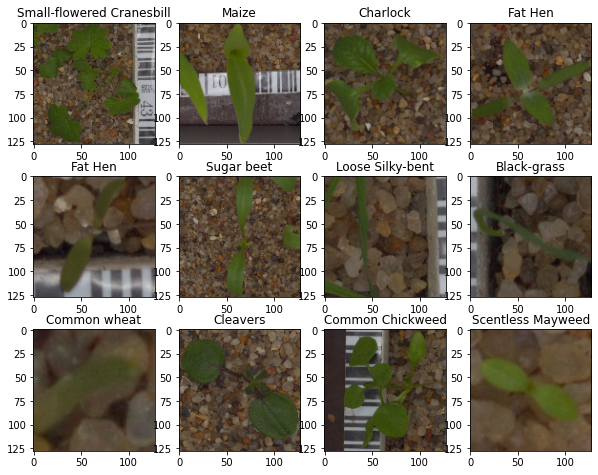

In [6]:
plot_images(images,labels)   

<b> Checking for data imbalance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

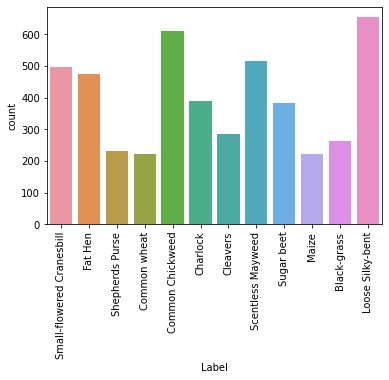

In [7]:
sns.countplot(labels['Label'])            
plt.xticks(rotation='vertical')

### <b>Resizing images 
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [8]:
images_decreased=[]
height = 64                   
width =  64                   
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

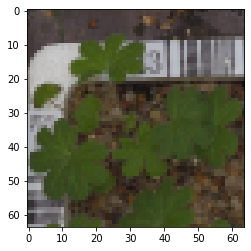

In [9]:
plt.imshow(images_decreased[3])

In [10]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)   # Complete the code to split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       # Complete the code to split the data with test_size as 0.1

In [11]:
# Complete the code to check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


## Encoding the target labels

In [12]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()                                       
y_train_encoded = enc.fit_transform(y_train)        
y_val_encoded=enc.transform(y_val)                  
y_test_encoded=enc.transform(y_test)               

In [13]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    

((3847, 12), (428, 12), (475, 12))

In [14]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data. 

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [15]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [16]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [17]:
model1 = Sequential()

model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(12, activation='softmax'))

opt=Adam(learning_rate=0.001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

### <b> Fitting the model on the train data

In [18]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 10s - loss: 2.4298 - accuracy: 0.1341 - val_loss: 2.3989 - val_accuracy: 0.1402 - 10s/epoch - 83ms/step
Epoch 2/30
121/121 - 1s - loss: 2.1137 - accuracy: 0.2683 - val_loss: 1.8213 - val_accuracy: 0.3925 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 1s - loss: 1.6439 - accuracy: 0.4240 - val_loss: 1.5783 - val_accuracy: 0.4603 - 1s/epoch - 11ms/step
Epoch 4/30
121/121 - 1s - loss: 1.4072 - accuracy: 0.5066 - val_loss: 1.3142 - val_accuracy: 0.5514 - 1s/epoch - 11ms/step
Epoch 5/30
121/121 - 1s - loss: 1.2030 - accuracy: 0.5854 - val_loss: 1.0703 - val_accuracy: 0.6402 - 1s/epoch - 11ms/step
Epoch 6/30
121/121 - 1s - loss: 1.0455 - accuracy: 0.6371 - val_loss: 1.0196 - val_accuracy: 0.6682 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 1s - loss: 0.9057 - accuracy: 0.6891 - val_loss: 0.8926 - val_accuracy: 0.7360 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 0.8092 - accuracy: 0.7177 - val_loss: 0.8392 - val_accuracy: 0.7313 - 1s/epoch - 11ms/step
Epoch 9/30
121

### **Model Evaluation**

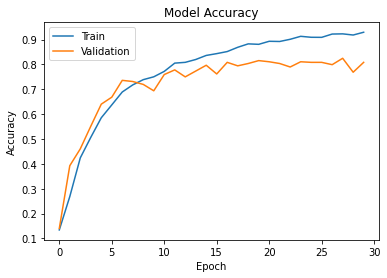

In [19]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Evaluate the model on test data**

In [20]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    

15/15 - 0s - loss: 0.8716 - accuracy: 0.7853 - 240ms/epoch - 16ms/step


### **Plotting the Confusion Matrix**





*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





In [21]:
y_pred=model1.predict(X_test_normalized)                      

15/15 [==============================] - 0s 5ms/step


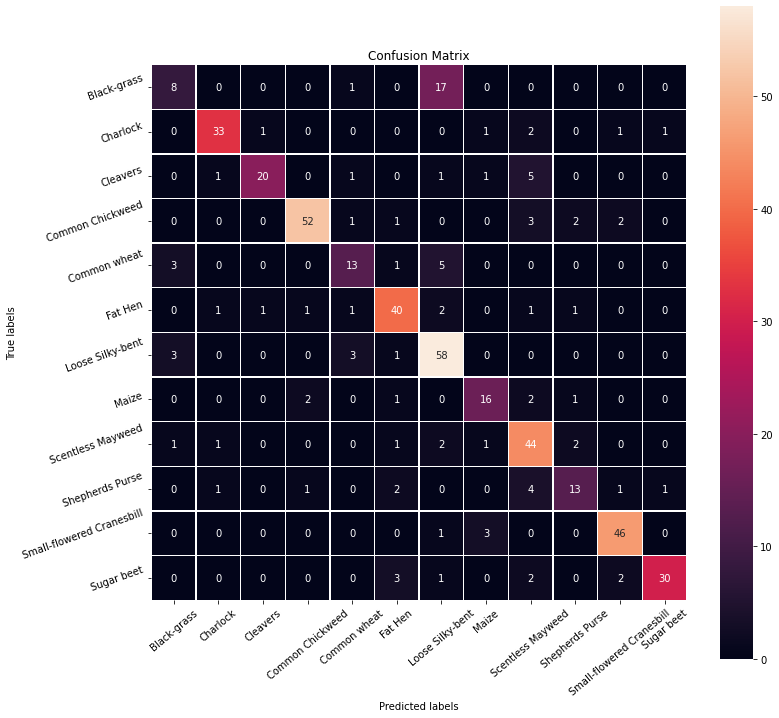

In [22]:
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)           
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

<b> Deleting the model and history variable to use the RAM efficiently

### **Plotting Classification Report**

In [23]:
from sklearn import metrics
 
cr=metrics.classification_report(y_test_arg,y_pred_arg)    
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.31      0.39        26
           1       0.89      0.85      0.87        39
           2       0.91      0.69      0.78        29
           3       0.93      0.85      0.89        61
           4       0.65      0.59      0.62        22
           5       0.80      0.83      0.82        48
           6       0.67      0.89      0.76        65
           7       0.73      0.73      0.73        22
           8       0.70      0.85      0.77        52
           9       0.68      0.57      0.62        23
          10       0.88      0.92      0.90        50
          11       0.94      0.79      0.86        38

    accuracy                           0.79       475
   macro avg       0.78      0.74      0.75       475
weighted avg       0.79      0.79      0.78       475



In [24]:
del model1
del history_1   

# **Improving the Base Model using Data Augmentation and Regularization**




In [25]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


### **Data Augmentation**


Remember, **data augmentation should not be used in the validation/test data set**.

In [26]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [27]:
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )

In [28]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(12, activation='softmax'))
opt=Adam(lr=0.001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [29]:
epochs = 30
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 5s 78ms/step - loss: 2.2434 - accuracy: 0.1832 - val_loss: 2.4276 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 4s 71ms/step - loss: 1.7964 - accuracy: 0.3526 - val_loss: 2.3678 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 4s 70ms/step - loss: 1.5542 - accuracy: 0.4467 - val_loss: 2.1502 - val_accuracy: 0.3925 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 4s 70ms/step - loss: 1.4366 - accuracy: 0.4843 - val_loss: 2.0899 - val_accuracy: 0.5304 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 4s 70ms/step - loss: 1.3138 - accuracy: 0.5303 - val_loss: 1.7885 - val_accuracy: 0.4836 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 4s 71ms/step - loss: 1.2210 - accuracy: 0.5580 - val_loss: 1.5739 - val_accuracy: 0.5818 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 4s 69ms/step - loss: 1.1

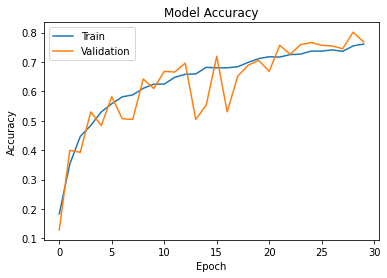

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

15/15 - 0s - loss: 0.7235 - accuracy: 0.7663 - 147ms/epoch - 10ms/step


In [32]:
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


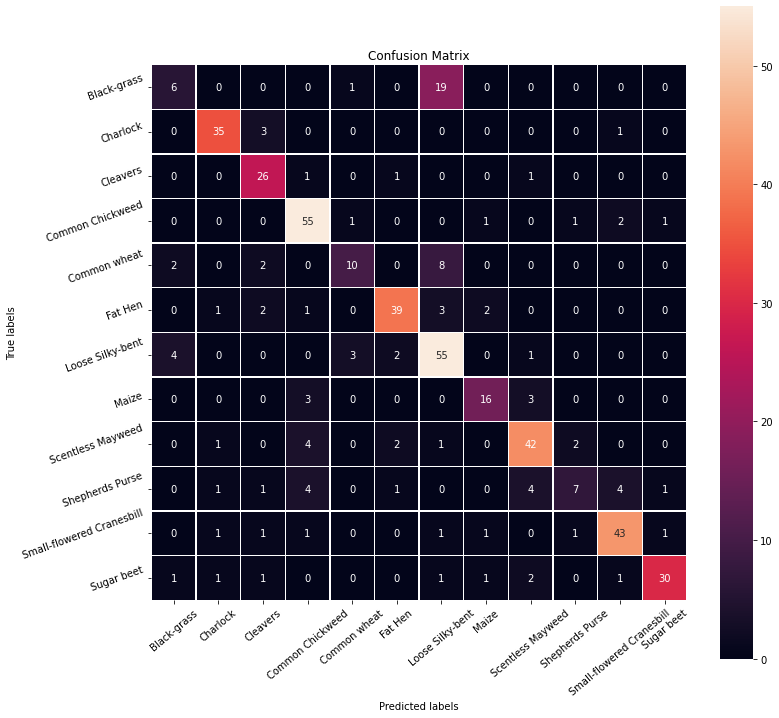

In [33]:
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg) 
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [34]:
# Plotting the classification report 
cr=metrics.classification_report(y_test_arg,y_pred_arg)    
print(cr)

              precision    recall  f1-score   support

           0       0.46      0.23      0.31        26
           1       0.88      0.90      0.89        39
           2       0.72      0.90      0.80        29
           3       0.80      0.90      0.85        61
           4       0.67      0.45      0.54        22
           5       0.87      0.81      0.84        48
           6       0.62      0.85      0.72        65
           7       0.76      0.73      0.74        22
           8       0.79      0.81      0.80        52
           9       0.64      0.30      0.41        23
          10       0.84      0.86      0.85        50
          11       0.91      0.79      0.85        38

    accuracy                           0.77       475
   macro avg       0.75      0.71      0.72       475
weighted avg       0.76      0.77      0.75       475



## **Visualizing the prediction:**

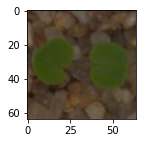

1/1 [==============================] - 0s 65ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


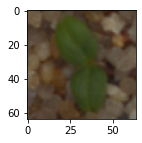

1/1 [==============================] - 0s 16ms/step
Predicted Label ['Cleavers']
True Label Cleavers


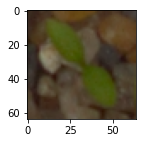

1/1 [==============================] - 0s 15ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


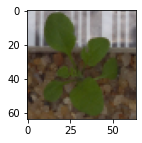

1/1 [==============================] - 0s 14ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [35]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

In [38]:
%%shell
jupyter nbconvert --to html Plant_Seedling_Classification.ipynb

[NbConvertApp] Converting notebook Plant_Seedling_Classification.ipynb to html
[NbConvertApp] Writing 1192659 bytes to Plant_Seedling_Classification.html
